<a href="https://colab.research.google.com/github/AtSourav/CatsnDogs_VAE/blob/main/temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras       # cannot use the name tf to import modules, can only use it to call functions or modules
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras.datasets import mnist

import os
import matplotlib.pyplot as plt


In [2]:
input_size = (14,14,1)
latent_dim = 8
batch_size = 64


In [2]:
(img_train, tg_train), (img_valid, tg_valid) = mnist.load_data()

img_ht = img_train.shape[1]         #the shape of the data is (count, ht, wd)
img_wd = img_train.shape[2]
count_train = img_train.shape[0]
count_valid = img_valid.shape[0]

img_train = img_train.reshape(count_train,img_ht,img_wd, 1)     # we are adding the channel axis manually
img_valid = img_valid.reshape(count_valid,img_ht,img_wd, 1)

print(img_train.shape)
print(img_valid.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
img_train = layers.Resizing(14, 14, interpolation="bilinear")(img_train)
img_valid = layers.Resizing(14, 14, interpolation="bilinear")(img_valid)

img_train = img_train/255.
img_valid = img_valid/255.

print(img_train.shape)
print(img_valid.shape)


(60000, 14, 14, 1)
(10000, 14, 14, 1)


In [5]:
l2_reg = keras.regularizers.L2(l2=0.01)

In [6]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(10, 2, padding="valid")(encoder_input)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same")(x)    # with strides=None this defaults to pool_size
#x = layers.SpatialDropout2D(0.01)(x)
x = layers.BatchNormalization(axis=-1)(x) # the default data_format in the conv2d is "channels last", we want to normalize across the channels, hence we set axis=-1
x = layers.ReLU()(x)

x = layers.Conv2D(30, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid")(x)
#x = layers.SpatialDropout2D(0.01)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(50, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
x = layers.SpatialDropout2D(0.001)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)

#x = layers.Dense(8*latent_dim)(x)
x = layers.Dense(2*latent_dim, kernel_regularizer=l2_reg)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(arg):
  z_m, z_log_v = arg
  batch = tf.shape(z_m)[0]
  dim = tf.shape(z_m)[1]
  eps = tf.random.normal(shape=(batch,dim))
  return z_m + tf.exp(0.5*z_log_v)*eps

z = layers.Lambda(sampling)([z_mean,z_log_var])   # we feed the sampling function in to a Lambda layer to build form a layer for the architecture as keras needs

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')           # the second argument specifies that the encoder outputs [z_mean, z_log_var, z] for each input.
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 14, 14, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 13, 13, 10)           50        ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 7, 7, 10)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 7, 7, 10)             40        ['max_pooling2d[0][0]'] 

The number of trainable parameters might just be too big for the dataset, possibility of overtraining, we'll see how it goes. Let's make the decoder now.

In [7]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim, kernel_regularizer=l2_reg)(latent_input)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x
                  )
x = layers.Dense(30, kernel_regularizer=l2_reg)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Dense(50, kernel_regularizer=l2_reg)(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Reshape((1,1,50))(x)

x = layers.Conv2DTranspose(30, 2, strides=2, padding='same')(x)
x = layers.SpatialDropout2D(0.001)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(20, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(10, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(1, 2, activation='sigmoid', strides=2, padding='same')(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 batch_normalization_4 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                510       
                                                                 
 batch_normalization_5 (Bat  (None, 30)                120       
 chNormalization)                                          

Now let's instantiate the VAE by combininb the encoder and the decoder layers.

In [8]:
decoder_out = decoder(encoder(encoder_input)[2])          # we feed in z from the encoder output
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 8),               8842      
                              (None, 8),                         
                              (None, 8)]                         
                                                                 
 decoder (Functional)        (None, 14, 14, 1)         12129     
                                                                 
Total params: 20971 (81.92 KB)
Trainable params: 20447 (79.87 KB)
Non-trainable params: 524 (2.05 KB)
_________________________________________________________________


We shall define the loss function now, it's made of the reconstruction loss that tries to ensure repoducibility of the data, and the KL divergence loss that tries to ensure that the learned (approximate) posterior is close to the true posterior. Since we have continuous values for the pixels, we cannot use the Bernoulli log loss (binary cross entropy) for the reconstruction loss, we shall use mean squared error. In a different version, we shall try to implement a continuous version of the Bernoulli log loss based on 1907.06845.

We shall keep a relative weight beta between the two terms in the total loss as a hyperparameter. We may want to investigate the effects of varying this hyperparameter eventually.

The custom loss function needs to be a callable of the form fn(true, pred) to be compatible with Model.compile() and Model.fit(). The reconstruction loss will calculate the mse between the true and predicted images directly. The kl divergence loss is a function of z_mean and z_log_var that will be used directly from the values while evaluating the forward pass. For further details, look up the source code for the compile() and fit() methods in the Model class, and also for train_step(), compute_loss(), and make_train_function()

In [9]:
beta = 1  # we shall vary this later

#@tf.function
def vae_loss(true,pred):
  mse = losses.MeanSquaredError()
  reconstruction_loss = mse(K.flatten(true),K.flatten(pred))    # the input and the output for the model, which are 160*160*3 images will be taken as true and pred, respectively.
                                                                                              # layers.Flatten() is not appropriate here as it works on (batch, ht, wd, chan) to give (batch, flattened)
                                                                                              # converting to a numpy ndarray seems tricky here, .numpy() does not seem to work since it seems like we're not in earger execution mode

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)/(14*14)    # summing along the columns with tf.reduce_sum, if we chose to take mean instead of sum at this step, we shouldn't multiply with the dimensions for the reconstruction loss.
                                                                                                                # taking the mean along the batches with tf.reduce_mean, the mse for the reconstruction loss also takes the mean along the batches

  return reconstruction_loss + beta*kl_div

In [10]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.8, staircase=True)
optim = keras.optimizers.Adam(learning_rate = lr_decay)
VAE.compile(optimizer=optim,loss=vae_loss)

In [11]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)


Epoch 1/10
938/938 [==============================] - 60s 38ms/step - loss: 0.8289 - val_loss: 0.6678
Epoch 2/10
938/938 [==============================] - 31s 33ms/step - loss: 0.6221 - val_loss: 0.5985
Epoch 3/10
938/938 [==============================] - 32s 34ms/step - loss: 0.5915 - val_loss: 0.5872
Epoch 4/10
938/938 [==============================] - 30s 32ms/step - loss: 0.5865 - val_loss: 0.5851
Epoch 5/10
938/938 [==============================] - 31s 33ms/step - loss: 0.5854 - val_loss: 0.5847
Epoch 6/10
937/938 [============================>.] - ETA: 0s - loss: 0.5852

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])         # history.history is a dict with performance metrics as keys
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def plot_latent_space(n=20, figsize=15, scale=1.5, slice_ax=tuple(np.zeros((latent_dim-2,),dtype=int))):              # slice_ax should be a tuple of length latent_dim -2 , it picks some particular values along the last latent_dim -2 components of the latent space
                                                                           # slice_ax needs to be passed as a tuple, having it as a list picks the values specified along dim 1 instead of picking one value along each of the first latent_dim -2 dimensions
    digit_size = input_size[0]
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_axis = np.linspace(-scale, scale, n)
    grid = np.array(np.meshgrid(*[grid_axis for i in range(latent_dim)]))    # * unpacks the list

    np.testing.assert_array_equal(grid.shape,np.concatenate(([latent_dim],[n for i in range(latent_dim)]),axis=None))  # each point in the grid should be an latent_dim dimensional vector, if not, we'll have an assertion error

    grid_new  = np.moveaxis(grid,0,latent_dim-2)[slice_ax]   # slicing a 2D mesh of latent_dim dimensional vectors from the n-dimensional mesh.

    np.testing.assert_array_equal(grid_new.shape, (latent_dim,n,n))

    for i in range(n):
        for j in range(n):
            z_sample = np.array([grid_new[:,i,j]])
            x_decoded = decoder(z_sample)
            digit = tf.reshape(x_decoded[0],(digit_size, digit_size))
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_axis, 1)
    sample_range_y = np.round(grid_axis, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()



In [ ]:
plot_latent_space(n=7,scale = 1,figsize=7,slice_ax=(2,7,4,5,1))

In [ ]:
# it seems like the kl divergence term in the loss acts as a regularizer to the reconstruction term, increasing beta seems to help with reducing overfitting. This makes sense as the kl divergence term is supposed to smoothen the latent distribution
# how is it different from incorporating more standard regularizers into the architecture: regularise by other means, use beta to control generlisation performance

In [ ]:
plot_latent_space(n=9,scale = 1,figsize=9,slice_ax=(0,1,4,7,2))

In [3]:
tg_train[1:10]

array([0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

[7 4 5 2 7 3 6 7 8 4 6 4 4 7 6 4 3 6 2 9 9 0 0 3 2 7 6 9 8 3 3 6 8 2 2 7 7
 3 2 0 9 7 1 0 7 3 2 6 7 2 8 7 8 4 0 8 5 6 1 1 4 2 9 2 3 6 5 1 5 5 1 7 2 8
 1 4 8 2 6 7 6 9 2 9 7 2 9 9 1 8 3 9 6 3 2 7 2 4 7 6]
[2 2 1 9 8 5 3 8 0 4 3 8 4 3 8 2 2 7 6 3 7 6 4 5 1 6 4 3 8 1 3 1 2 9 5 2 8
 0 3 9 9 1 8 6 3 0 0 9 8 8 2 7 1 5 9 3 8 8 9 4 6 1 8 5 0 2 9 8 2 4 3 1 9 8
 4 9 4 1 3 3 1 7 1 9 3 8 3 8 0 4 7 7 4 0 7 7 4 8 1 3]


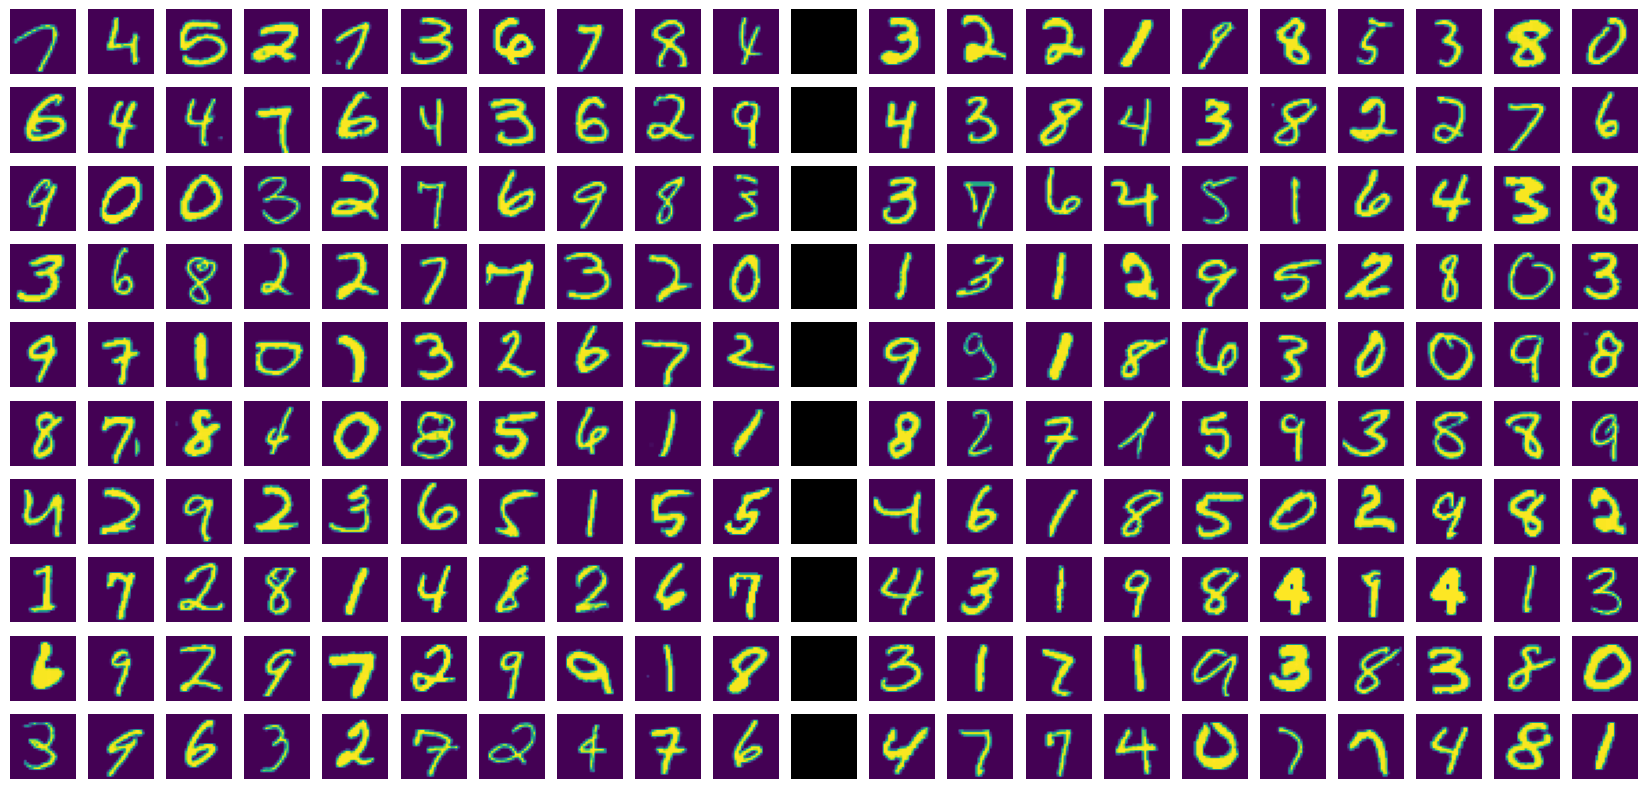

In [29]:
np.random.seed(111)

tr_tg_indices = np.random.randint(0,60000,size = 100)
va_tg_indices = np.random.randint(0,10000,size = 100)
print(tg_train[tr_tg_indices])
print(tg_valid[va_tg_indices])

digits = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
for i in range(210):
  digits.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_train[tr_tg_indices[j*10 + (i%21)]]
    plt.imshow(img)
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_valid[va_tg_indices[j*10 + (i%21) - 12]]
    plt.imshow(img)
    plt.axis('off')
